In [27]:
import numpy as np
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [4]:
print("hello")

hello


In [5]:
# 1.Data
df = pd.read_csv('dengue_features_train.csv')
df_labels = pd.read_csv('dengue_labels_train.csv')

In [6]:
print(df.head())

  city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0   sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1   sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2   sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3   sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4   sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   

    ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k        ...          \
0  0.177617                 12.42             297.572857        ...           
1  0.155486                 22.82             298.211429        ...           
2  0.170843                 34.54             298.781429        ...           
3  0.235886                 15.36             298.987143        ...           
4  0.247340                  7.52             299.518571        ...           

   reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0   

In [10]:
df2 = df.merge(df_labels, how='inner')
df2 = df2.dropna()
df2 = df2.drop('week_start_date', axis=1)
df2 = df2.drop('city', axis=1)
df2.dtypes

year                                       int64
weekofyear                                 int64
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rng_c                  float64
station_max_temp_c                       float64
station_min_temp_c  

In [11]:
y = df2['total_cases'].values
X = df2.drop('total_cases',axis=1).values

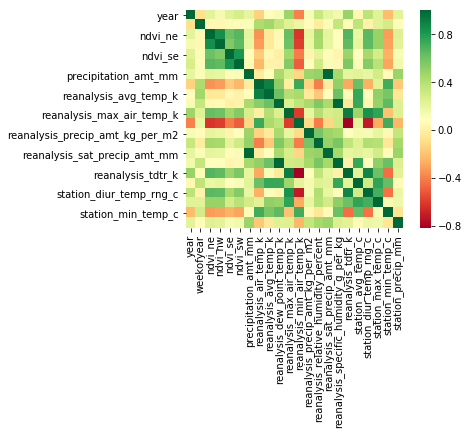

In [12]:
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')
plt.show()

In [13]:
#Testing linear regression minus categorical and date variables 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3,random_state=42)
reg_all = LinearRegression()
reg_all.fit(X_train,y_train)
y_pred = reg_all.predict(X_test)

In [15]:
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print("Standard deviation actual target data: {}".format(np.std(y)))
print("Mean actual target data: {}".format(np.mean(y)))

R^2: 0.265169144276
Root Mean Squared Error: 27.0898657797
Standard deviation actual target data: 30.843685015
Mean actual target data: 21.1976647206


In [53]:
#Now we are going to try 5 fold cross validation with Rsquared
reg = linear_model.LinearRegression()
cv_scores = cross_val_score(reg, X, y, cv = 5)
print(cv_scores)
print("Average cv score: {}".format(np.mean(cv_scores)))
cv_scores = cross_val_score(reg, X, y, cv = 10)
print(cv_scores)
#OMG this model is terrible
print("Average cv score: {}".format(np.mean(cv_scores)))

[ 0.05296225  0.06589237 -0.16687003 -2.04779371 -1.82906087]
Average cv score: -0.784973996077
[ 4.37396048e-03 -7.16680772e-02 -4.97302026e-02  8.72369067e-02
 -5.41379057e+00  1.35003837e-01 -3.96241431e+00 -1.67444976e-01
 -3.41674257e+00 -1.04562508e+00]
Average cv score: -1.39008010852


In [42]:
#Testing XGBoost with base trees
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3,random_state=42)
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = 15, seed = 46)
xg_reg.fit(X_train, y_train)
predictions = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 24.0321554497


In [43]:
#Testing XGBoost with base lines
DM_train = xgb.DMatrix(data = X_train, label = y_train)
DM_test = xgb.DMatrix(data = X_test, label = y_test)
params = {"booster":"gblinear", "objective":"reg:linear"}
xg_reg = xgb.train(params=params, dtrain=DM_train,num_boost_round=15)
predictions = xg_reg.predict(DM_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error: {}".format(rmse))




Root Mean Squared Error: 28.7719528574


In [52]:
#Cross validation for XGBoost
dmatrix_XGB = xgb.DMatrix(data = X, label = y)
params = {"objective":"reg:linear", "max_depth": 5}
cv_xgb_result = xgb.cv(dtrain=dmatrix_XGB, params=params, nfold=5, num_boost_round=5, 
                       metrics="rmse", as_pandas = True, seed=46)
print(cv_xgb_result)

[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:13:23] /work